In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import nltk
from nltk.corpus import gutenberg
nltk.download('punkt')
nltk.download('gutenberg')
import re
from sklearn.model_selection import train_test_split

#reading in the data, this time in the form of paragraphs
melville=gutenberg.paras('melville-moby_dick.txt')
#processing
melville_paras=[]
for paragraph in melville:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    melville_paras.append(' '.join(para))

print(melville_paras[0:4])

[nltk_data] Downloading package punkt to C:\Users\Square
[nltk_data]     Bear\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to C:\Users\Square
[nltk_data]     Bear\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


['[ Moby Dick by Herman Melville 1851 ]', 'ETYMOLOGY .', '( Supplied by a Late Consumptive Usher to a Grammar School )', 'The pale Usher  threadbare in coat , heart , body , and brain ; I see him now .']


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(melville_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
melville_paras_tfidf=vectorizer.fit_transform(melville_paras)
print("Number of features: %d" % melville_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(melville_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 3778
Original sentence: " Sir ?"
Tf_idf vector: {'sir': 1.0}


In [4]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])




Percent variance captured by all components: 36.23051487662279
Component 0:
CHAPTER 107    0.999994
CHAPTER 111    0.999994
CHAPTER 81     0.999994
CHAPTER 15     0.999994
CHAPTER 8      0.999994
CHAPTER 60     0.999994
CHAPTER 100    0.999994
CHAPTER 77     0.999994
CHAPTER 73     0.999994
CHAPTER 135    0.999994
Name: 0, dtype: float64
Component 1:
" I do , sir ."                 0.869369
" Sir ?"                        0.869369
" Sir ?                         0.869369
" Sir ."                        0.869369
" No , Sir , I never have ."    0.869369
" Nothing , sir ."              0.869369
" Nothing , nothing sir !"      0.869369
" Sir ?"                        0.869369
Sir ?                           0.869369
Sir ? Clay ?                    0.869369
Name: 1, dtype: float64
Component 2:
" WHAT whale ?"                                                                                                                                                                                         

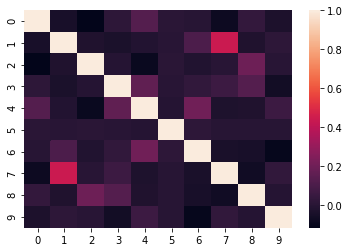

Key:
0 " There he goes now ; to him nothing ' s happened ; but to me , the skewer seems loosening out of the middle of the world .
1 Finally , I always go to sea as a sailor , because of the wholesome exercise and pure air of the fore - castle deck .
2 " Pedestrians in the vicinity of London and elsewhere may recollect having seen large curved bones set upright in the earth , either to form arches over gateways , or entrances to alcoves , and they may perhaps have been told that these were the ribs of whales ."
3 " He says , Monsieur ," said the Guernsey - man , in French , turning to his captain , " that only yesterday his ship spoke a vessel , whose captain and chief - mate , with six sailors , had all died of a fever caught from a blasted whale they had brought alongside ."
4 " Why ," said I , " he ' s a member of the first Congregational Church ."
5 " Sir ?"
6 " Cherries ?
7 They went towards the extreme stern , on the ship ' s lee side , where the deck , with the oblique energy of

In [5]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


In [6]:
#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
#svd= TruncatedSVD(130)
#lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_test_lsa = lsa.fit_transform(X_test_tfidf)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
CHAPTER 127    0.999994
CHAPTER 97     0.999994
CHAPTER 88     0.999994
CHAPTER 46     0.999994
CHAPTER 7      0.999994
CHAPTER 118    0.999994
CHAPTER 56     0.999994
CHAPTER 87     0.999994
CHAPTER 70     0.999994
CHAPTER 104    0.999994
Name: 0, dtype: float64
Component 1:
" Sir !"                                                                            0.717805
He must be forging the buckle - screw , sir , now .                                 0.717805
" See nothing , sir ."                                                              0.717805
" What was it , Sir ?"                                                              0.717805
I should humbly call it a poser , sir .                                             0.717805
" Sing , sir ?                                                                      0.709046
Perhaps an hour , sir .                                                             0.703618
" The anchors are working , sir .                          

In [7]:
vectorizer = TfidfVectorizer(max_df=0.25, # drop words that occur in more than 25% of the paragraphs
                             min_df=3, # only use words that appear at least 3 times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
melville_paras_tfidf=vectorizer.fit_transform(melville_paras)
print("Number of features: %d" % melville_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(melville_paras_tfidf, test_size=0.4, random_state=0)

Number of features: 2313


In [8]:
# Keep same number of components
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Fit with train data
X_train_lsa = lsa.fit_transform(X_train_tfidf)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
CHAPTER 80     0.999991
CHAPTER 110    0.999991
CHAPTER 124    0.999991
CHAPTER 59     0.999991
CHAPTER 22     0.999991
CHAPTER 111    0.999991
CHAPTER 113    0.999991
CHAPTER 73     0.999991
CHAPTER 62     0.999991
CHAPTER 44     0.999991
Name: 0, dtype: float64
Component 1:
Sir ? Clay ?                    0.681514
" I do , sir ."                 0.681514
" Nothing , nothing sir !"      0.681514
" Sir ?"                        0.681514
" Sir ."                        0.681514
" Sir ?"                        0.681514
" No , Sir , I never have ."    0.681514
" Nothing , sir ."              0.681514
Sir ?                           0.681514
" Sir ?                         0.681514
Name: 1, dtype: float64
Component 2:
" Nothing , nothing sir !"      0.683758
Sir ? Clay ?                    0.683758
" No , Sir , I never have ."    0.683758
Sir ?                           0.683758
" Sir ?                         0.683758
" Sir ."                        0.683758
" Sir ?"         

In [9]:

X_test_lsa = lsa.fit_transform(X_test_tfidf)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
CHAPTER 16     0.999992
CHAPTER 103    0.999992
CHAPTER 27     0.999992
CHAPTER 33     0.999992
CHAPTER 101    0.999992
CHAPTER 92     0.999992
CHAPTER 98     0.999992
CHAPTER 12     0.999992
CHAPTER 41     0.999992
CHAPTER 56     0.999992
Name: 0, dtype: float64
Component 1:
" The whale !                                                                                                                                                                   0.570914
" This whale ' s liver was two cartloads ."                                                                                                                                     0.570914
" WHALE .                                                                                                                                                                       0.570914
But these manifold mistakes in depicting the whale are not so very surprising after all .                                                                  

In [10]:
# Reduce to 50 components
svd= TruncatedSVD(50)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
CHAPTER 69     0.999996
CHAPTER 14     0.999996
CHAPTER 22     0.999996
CHAPTER 73     0.999996
CHAPTER 111    0.999996
CHAPTER 5      0.999996
CHAPTER 124    0.999996
CHAPTER 59     0.999996
CHAPTER 80     0.999996
CHAPTER 99     0.999996
Name: 0, dtype: float64
Component 1:
" No , sir ; not yet ," said Stubb , emboldened , " I will not tamely be called a dog , sir ."                                                                                                                                            0.726673
Truly , sir , I begin to understand somewhat now .                                                                                                                                                                                        0.700247
Starting at the unforseen concluding exclamation of the so suddenly scornful old man , Stubb was speechless a moment ; then said excitedly , " I am not used to be spoken to that way , sir ; I do but less than half like it , 

In [11]:
# Run SVD on the training data, then project the training data.
X_test_lsa = lsa.fit_transform(X_test_tfidf)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
CHAPTER 102    0.999996
CHAPTER 123    0.999996
CHAPTER 27     0.999996
CHAPTER 54     0.999996
CHAPTER 101    0.999996
CHAPTER 92     0.999996
CHAPTER 71     0.999996
CHAPTER 53     0.999996
CHAPTER 41     0.999996
CHAPTER 104    0.999996
Name: 0, dtype: float64
Component 1:
" The Spermacetti Whale found by the Nantuckois , is an active , fierce animal , and requires vast address and boldness in the fishermen ."                                                                                                                                                                                                    0.591984
" WHALE .                                                                                                                                                                                                                                                                                                                                      0.581204
" This whale ' s liver